In [80]:
import numpy as np 
import matplotlib.pyplot as plt

In [81]:
class YieldFunction():
    def __init__(self, name, mode, function, num_args, range): 
        self.name = name
        self.mode = mode
        # assumed now that the function can successfully be applied on numpy arrays. 
        # can modify code to be generalized to all types of functions
        self.function = function
        
        self.num_args = num_args
        self.range = range
    def return_yield(self, values): 
        
        if self.num_args == 1: 
            return self.function(values)
        elif self.num_args == 2: 
            # this assumes that the values are stored as a n by 2 numpy array 
            return self.function(values[:, 0], values[:, 1])
        else:
            raise AssertionError("return_yield, not yet implemented >2 dimensional")
    def plot_function(self):
        if self.num_args == 1:
            total_values = np.linspace(self.range[0], self.range[1])
            plt.plot(total_values, self.return_yield(total_values))
            plt.title(f"Yield over range for {self.name}")
            plt.ylabel("Yields")
            plt.xlabel(f"{self.mode} values across range")

9


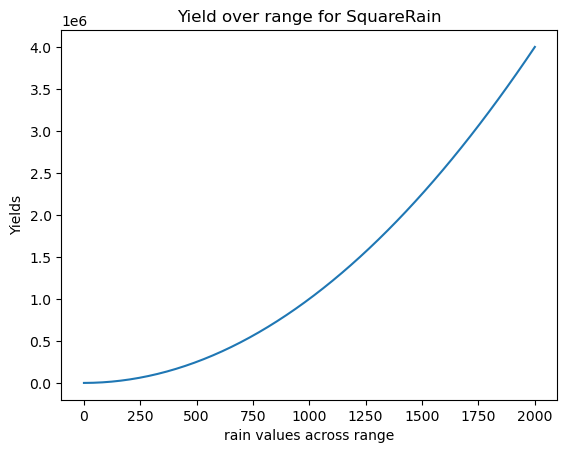

In [82]:
test = YieldFunction(name = "SquareRain", mode = "rain", function = np.square, num_args = 1, range = [1,2000])
print(test.return_yield(3))
test.plot_function()

In [83]:
# Great! Now we should define some yield functions that we can just use 
growing_rain_yield_functions = []
def flat_grow_rain(sum_rain):
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [600, 1000])
    # if sum_rain <= 800: 
    #     return 600
    # else:
    #     return 1000
def single_thresh_grow_rain(sum_rain):
    alpha = 0.5 
    # if sum_rain >= 800:
    #     return 1000
    # else:
    #     return 1000 - alpha * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1000 - alpha * (800 - x), 1000])
def double_kink_grow_rain(sum_rain):
    alpha = 0.5 
    beta = 1.0
    # if sum_rain >= 800:
    #     return 1000
    # elif sum_rain >= 650:
    #     return 1000 - alpha * (800 - sum_rain)
    # else: 
    #     return 1000 - beta * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain >= 800, sum_rain < 800, sum_rain < 650], [1000, lambda x: 800 - alpha * (800 - x), lambda x: 725 - beta * (650 - x)])

def quad_grow_rain(sum_rain):
    alpha = 0.00155
    beta = 800
    gamma = 1000
    return - (alpha * (sum_rain - beta)**2) + gamma
def abs_grow_rain(sum_rain):
    alpha = 0.75
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1000 - alpha * (800 - x), lambda x: 1000 + alpha * (800 - x)])


In [84]:
flat_rain = YieldFunction(name = "FlatRain", mode = "rain", function = flat_grow_rain, num_args = 1, range = [0,1500])
single_lin_rain = YieldFunction(name = "SingleLinRain", mode = "rain", function = single_thresh_grow_rain, num_args = 1, range = [0,1500])
double_lin_rain = YieldFunction(name = "DoubleLinRain", mode = "rain", function = double_kink_grow_rain, num_args = 1, range = [0,1500])
quad_rain = YieldFunction(name = "QuadRain", mode = "rain", function = quad_grow_rain, num_args = 1, range = [0,1500])
abs_rain = YieldFunction(name = "AbsRain", mode = "rain", function = abs_grow_rain, num_args = 1, range = [0,1500])
growing_rain_yield_functions.extend([flat_rain, single_lin_rain, double_lin_rain, quad_rain, abs_rain])

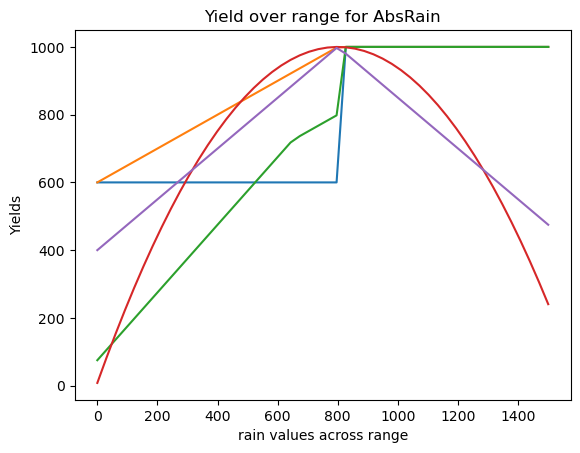

In [85]:
for _ in growing_rain_yield_functions:
    _.plot_function()

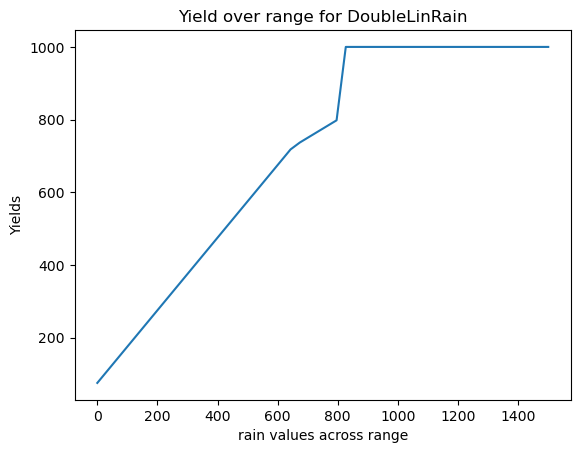

In [86]:
double_lin_rain.plot_function()

In [87]:
# to simplify, assume it's a flat penalty for harvest rain, ie. just reduce yields by 15% 
# Great! Now we should define some yield functions that we can just use 
def add_harvest(grow_yield_function, alpha = 0.85):
    # find the normal yield from growth. if harvest_rain is bad, then multiply by penalty factor 
    def proper_yield(grow_rain, harvest_rain):
        harvest_rain_multiplier = np.piecewise(harvest_rain.astype(float), [harvest_rain <= 30, harvest_rain > 30], [alpha, 1.0])
        grow_rain_yield = grow_yield_function(grow_rain)
        return_list = np.multiply(grow_rain_yield, harvest_rain_multiplier)
        return return_list
        
    return proper_yield


In [88]:
x = add_harvest(flat_grow_rain)

In [89]:
x(np.array([900, 900]), np.array([20, 40]))

array([ 850., 1000.])

In [90]:
flat_rain_harvest = YieldFunction(name = "FlatRainHarvest", mode = "rain", function = add_harvest(flat_grow_rain), num_args = 2, range = [0, 1500])
flat_rain_harvest.return_yield(np.array([[900, 20],
                                         [800, 40],
                                         [400, 20]]))

array([ 850., 1000.,  510.])

In [91]:
flat_rain_harvest = YieldFunction(name = "FlatRainHarvest", mode = "rain", function = add_harvest(flat_grow_rain), num_args = 2, range = [0, 1500])
single_lin_harvest = YieldFunction(name = "SingleLinRainHarvest", mode = "rain", function = add_harvest(single_thresh_grow_rain), num_args = 2, range = [0,1500])
double_lin_rain_harvest = YieldFunction(name = "DoubleLinRainHarvest", mode = "rain", function = add_harvest(double_kink_grow_rain), num_args = 2, range = [0,1500])
quad_rain_harvest = YieldFunction(name = "QuadRainHarvest", mode = "rain", function = add_harvest(quad_grow_rain), num_args = 2, range = [0,1500])
abs_rain_harvest = YieldFunction(name = "AbsRainHarvest", mode = "rain", function = add_harvest(abs_grow_rain), num_args = 2, range = [0,1500])
growing_rain_yield_functions.extend([flat_rain_harvest, single_lin_harvest, double_lin_rain_harvest, quad_rain_harvest, abs_rain_harvest])

In [92]:
growing_rain_yield_functions

In [93]:
# now we have 2 dimensional rain yield functions, let's build functionality for adding variability of some kind 
# for now, let's think of some statically bound variabilitiy (ie. variance is a constant value that we define)
# in this model, assume that actual yield = predicted yield + N(0, gamma), gamma is the variance value 
class YieldSimulator():
    def __init__(self, yield_function): 
        self.yield_function = yield_function
    def simulate(self, data, gamma = 1 ):
        # data will come in a n by d format 
        # NEED TO MATCH THE DATA DIMENSIONS WITH THE YIELD FUNCTION DIMENSIONS
        predicted_yield = self.yield_function.return_yield(data)
        actual_yield = predicted_yield + np.random.normal(0, gamma, predicted_yield.shape)
        return predicted_yield, actual_yield
    def plot_simulated_yield(self, data, gamma = 1): 
        pred, actual = self.simulate(data, gamma)
        plt.plot(actual)
        plt.title(f'Actual Yield with Gamma = {gamma}')
        plt.plot(pred)
        plt.title(f"Predicted Yield with Gamma = {gamma}")


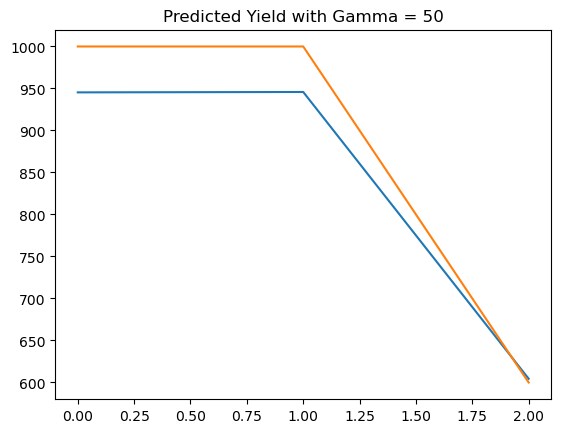

In [94]:
x = YieldSimulator(growing_rain_yield_functions[0])
x.simulate(np.array([[900],
                     [800],
                    [400]]), gamma = 50)
x.plot_simulated_yield(np.array([[900],
                     [800],
                    [400]]), gamma = 50)

In [95]:
#now let's build functionality for the insurance policies 
class InsurancePolicy():
    def __init__(self, num_args, function):
        self.num_args = num_args
        self.function = function
    def policy_payout(self, weather_data): 
        return self.function(weather_data)

In [96]:
import pandas as pd

In [97]:
#data is in mm of rainfall
#goal is to create a montecarlo simulator of monthly rain in a chosen region 
#(let's choose Madhya Pradesh because supposedly it accounts for most of soybean production at 58% of total india)

url_1 = '../data/district_wise_rainfall_normal.csv'  # https://data.gov.in/catalog/rainfall-i
district_wise_dataset = pd.read_csv(url_1) 
url_2 = '../data/Sub_Division_IMD_2017'
subdiv_df = pd.read_csv(url_2)
district_name_mp = district_wise_dataset["STATE_UT_NAME"].unique()
district_name_mp.sort()
mp_string = district_name_mp[19]
district_wise_dataset.set_index(["STATE_UT_NAME", "DISTRICT"],inplace=True)

In [98]:
subdiv_df.set_index(['SUBDIVISION','YEAR'], inplace=True)
west_mp = subdiv_df.loc['West Madhya Pradesh']
east_mp = subdiv_df.loc['East Madhya Pradesh']
#cleaning nans
west_mp.isnull().values.any()
west_mp_annual = west_mp['ANNUAL']
east_mp_annual = east_mp['ANNUAL']
columns_to_drop = west_mp.columns[12:]
east_mp_annual.mean()


1203.0350427350427

In [99]:
#ok prune extra columns
west_mp.drop(columns=columns_to_drop, inplace=True)
east_mp.drop(columns=columns_to_drop, inplace=True)
east_mp

/var/folders/hq/62b5kbn954ggcv_0g7_hdfmh0000gn/T/ipykernel_65298/999589201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_mp.drop(columns=columns_to_drop, inplace=True)
/var/folders/hq/62b5kbn954ggcv_0g7_hdfmh0000gn/T/ipykernel_65298/999589201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  east_mp.drop(columns=columns_to_drop, inplace=True)


,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1901,48.5,38.1,15.7,10.7,6.2,61.0,367.5,589.2,189.9,5.9,0.0,0.0
1902,14.9,8.9,0.0,3.6,2.7,28.0,411.9,227.0,236.6,17.0,27.6,6.1
1903,5.6,2.9,0.3,0.9,37.5,67.5,261.4,366.7,257.4,177.9,0.0,0.0
1904,2.0,15.3,48.2,0.0,8.6,109.9,443.2,316.6,135.6,44.8,3.2,16.9
1905,15.9,8.0,14.3,12.3,10.2,34.4,292.4,243.3,250.9,2.9,0.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2013,2.0,43.4,14.1,9.5,0.3,311.9,456.2,480.8,78.0,124.2,0.5,1.0
2014,32.1,49.7,17.8,5.1,2.5,91.8,283.4,231.8,139.6,56.4,1.9,12.9
2015,37.3,11.0,73.4,25.8,6.3,139.2,262.2,272.1,71.6,38.2,1.2,0.9


In [100]:
west_mp = west_mp.fillna(0)
west_mp.isnull().values.any()
east_mp = east_mp.fillna(0)
east_mp.isnull().values.any()
east_mp

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1901,48.5,38.1,15.7,10.7,6.2,61.0,367.5,589.2,189.9,5.9,0.0,0.0
1902,14.9,8.9,0.0,3.6,2.7,28.0,411.9,227.0,236.6,17.0,27.6,6.1
1903,5.6,2.9,0.3,0.9,37.5,67.5,261.4,366.7,257.4,177.9,0.0,0.0
1904,2.0,15.3,48.2,0.0,8.6,109.9,443.2,316.6,135.6,44.8,3.2,16.9
1905,15.9,8.0,14.3,12.3,10.2,34.4,292.4,243.3,250.9,2.9,0.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2013,2.0,43.4,14.1,9.5,0.3,311.9,456.2,480.8,78.0,124.2,0.5,1.0
2014,32.1,49.7,17.8,5.1,2.5,91.8,283.4,231.8,139.6,56.4,1.9,12.9
2015,37.3,11.0,73.4,25.8,6.3,139.2,262.2,272.1,71.6,38.2,1.2,0.9


In [101]:
east_mp.to_numpy().reshape(-1,1)
12 * len(east_mp) * 0.1
12 * len(east_mp) - (12 * len(east_mp) * 0.1)
west_mp.to_numpy().reshape(1,-1)[0]
len(east_mp.to_numpy().reshape(1,-1)[0]), len(west_mp.to_numpy().reshape(1,-1)[0])


(1404, 1404)

In [102]:
june = east_mp.to_numpy()[:, 5]
july = east_mp.to_numpy()[:, 6]
august = east_mp.to_numpy()[:, 7]
september = east_mp.to_numpy()[:, 8]
october = east_mp.to_numpy()[:, 9]

In [103]:
growing_rain_data = 0.5 * june + july + august + september
harvest_rain_data = october
growing_rain_data.shape, harvest_rain_data.shape

((117,), (117,))

In [104]:
g_mean, h_mean = np.mean(growing_rain_data), np.mean(harvest_rain_data)
g_std, h_std = np.std(harvest_rain_data), np.std(growing_rain_data)
print(g_mean, h_mean)
print(g_std)

1004.8914529914529 39.41623931623931
41.15314520442188


In [105]:
growing_rain_data.astype(int)

array([1177,  889,  919,  950,  803, 1164,  799, 1303,  855,  971,  937,
       1017,  707, 1076, 1043, 1099, 1320,  743, 1377,  802,  994, 1077,
       1350, 1191, 1162, 1430,  956,  799, 1074, 1042, 1078, 1027, 1048,
       1277, 1161, 1170, 1083, 1033, 1164, 1018,  664, 1267, 1106, 1115,
       1065, 1125, 1241, 1124, 1007, 1021,  959, 1002,  938,  991, 1101,
       1219,  853,  978, 1106, 1010, 1387,  910,  956, 1084,  609,  671,
       1198,  839, 1165, 1099, 1131,  931, 1103,  827, 1207,  953, 1066,
       1087,  584, 1188,  878, 1066, 1116,  952,  912,  736,  892,  908,
        777, 1109,  924, 1015, 1009, 1345,  886,  844, 1053,  849, 1276,
        781,  890,  815, 1290,  796, 1134,  804,  537,  808,  735,  877,
       1093,  957, 1170,  700,  675, 1203,  736])

(array([ 3.,  5., 12., 14., 17., 19., 23., 13.,  6.,  5.]),
 array([ 537.9  ,  627.155,  716.41 ,  805.665,  894.92 ,  984.175,
        1073.43 , 1162.685, 1251.94 , 1341.195, 1430.45 ]),
 <BarContainer object of 10 artists>)

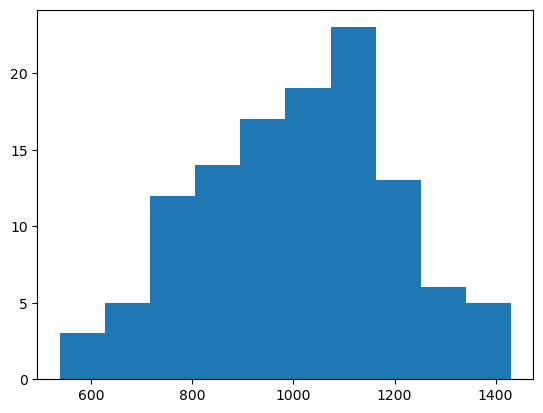

In [106]:
plt.hist(growing_rain_data)

In [107]:
harvest_rain_data.astype(int) # harvest rain data is extremeley variable

array([  5,  17, 177,  44,   2,   7,   0,  13,   0,  49,  62,   1,   2,
         8, 116, 177,  63,   0,  82,   0,   0,   6,  31,  29,  11, 135,
        67,  96,  17,  33, 151,  22,  61,  19,   2,  49, 100,  94,   7,
        35,   9,   1,  58,  50,  26,  32,  29,  22, 124,  13,  35,   8,
        16,   5, 119,  73,   6, 109,  61, 104,  65,   1,  27,  21,  11,
         2,   5,  20,   0,   3, 110,  25,  81,  76,  94,   0,  61,   8,
         6,   2,   4,  26,  64,  14,  97,  14,  81,  19,   1,  37,   5,
         7,  21,  24,   5,  47,  61,  20,  79,   1, 110,  43,  20,  25,
        27,  13,   3,  15,  68,  23,   1,  12, 124,  56,  38,  29,  18])

In [108]:
grow_rain = np.random.normal(g_mean, 2.5*g_std, size = (10000, 10)) # M by N matrix 
harvest_rain = np.random.normal(h_mean, h_std, size = (10, 10))
grow_rain.astype(int)

array([[ 978, 1001,  885, ...,  993, 1051,  887],
       [1133, 1075, 1089, ..., 1029,  907, 1010],
       [1073, 1061,  816, ...,  964, 1001, 1036],
       ...,
       [1081, 1001,  944, ..., 1023,  928,  835],
       [1057, 1028, 1037, ...,  922, 1084, 1222],
       [ 905, 1003, 1036, ..., 1025,  723,  994]])

(array([   60.,   799.,  4777., 16380., 29706., 28752., 14753.,  4123.,
          611.,    39.]),
 array([ 591.91164399,  675.44822453,  758.98480508,  842.52138563,
         926.05796618, 1009.59454673, 1093.13112727, 1176.66770782,
        1260.20428837, 1343.74086892, 1427.27744947]),
 <BarContainer object of 10 artists>)

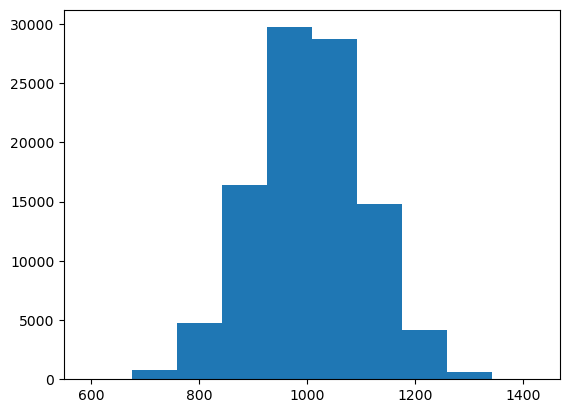

In [109]:
plt.hist(np.reshape(grow_rain, (-1, 1)))

In [251]:
def insurance_sim_rain(n_trials, n_years, yield_simulator, yield_to_cash, insurance_policy, yield_variability, premium = 250, seed = 1000):
    rng = np.random.default_rng(seed)
    print(yield_simulator.yield_function.name)
    grow_rain = np.random.normal(g_mean - 200, 2.5*g_std, size = (n_trials, n_years)) # M by N matrix 
    harvest_rain = np.random.normal(h_mean, h_std, size = (n_trials, n_years))


    rain_trials = [] 
    pred_yield_trials = [] 
    actual_yield_trials = []
    no_policy_cash_trials = []
    with_policy_cash_trials = []
    insurance_payouts_trials = []
    for trial in range(n_trials):
        grow_rain_i = grow_rain[trial]
        harvest_rain_i = harvest_rain[trial]
        #data_i = np.c_[grow_rain_i, harvest_rain_i]
        data_i = grow_rain_i
        pred, actual = yield_simulator.simulate(data_i, yield_variability)
        insurance_payout_i = insurance_policy(data_i)
        yield_to_cash_i = yield_to_cash(actual)

        premium_payments = - premium * np.ones(n_years)
        rain_trials.append(data_i)
        pred_yield_trials.append(pred)
        actual_yield_trials.append(actual)
        no_policy_cash_trials.append(yield_to_cash_i)

        with_policy_cash_trials.append(insurance_payout_i + yield_to_cash_i + premium_payments)
        insurance_payouts_trials.append(insurance_payout_i + premium_payments)
    #print(np.mean(insurance_payouts_trials))
    return np.array(rain_trials), np.array(pred_yield_trials), np.array(actual_yield_trials), np.array(no_policy_cash_trials), np.array(with_policy_cash_trials), np.array(insurance_payouts_trials)






In [252]:
# we need to develop the map from yield to cash
#data from marketing study done (2014 Solenkiatal)
# 2,195.00 2,258.00 2,290.00 2,241.00 in rupees per quintal received by the farmer
# but also 69,500.00 in returns, with costs of 32,071.44, so net income around 37,428.56
returns = 66080.00
yields = 20.65 
revenue_per_quintal = returns / yields
fixed_cost = 6251.75
variable_cost = 25711.87 - 901.43 # removed family cost as its not a direct cash cost
total_cost_per_hectare = fixed_cost + variable_cost
total_cost_per_hectare, revenue_per_quintal # 1 quintal = 100 kg of crops
def yield_to_cash_func(predicted_yield, rev_per_q = revenue_per_quintal, total_cost = total_cost_per_hectare): 
    return predicted_yield / 100 * revenue_per_quintal - total_cost

In [253]:
YieldSimulator(growing_rain_yield_functions[5])

In [254]:
def simple_insurance(data):
    grow_rain, harvest_rain = data[:, 0], data[:, 1]
    ### CHANGE NAME LATER 
    output = []
    for i in range(len(grow_rain)):
        grow_rain_i = grow_rain[i]
        harvest_rain_i = harvest_rain[i]
        
        return_amount = -1800
        if grow_rain_i <= 994:
            return_amount += 1900
        if harvest_rain_i >= 30:
            return_amount += 100
        output.append(return_amount) 
    return np.array(output)

In [255]:
sim_out = insurance_sim_rain(n_trials = 10, 
                   n_years = 10, 
                   yield_simulator = YieldSimulator(growing_rain_yield_functions[7]), 
                   yield_to_cash = yield_to_cash_func,
                   insurance_policy= simple_insurance,
                   yield_variability= 50)

DoubleLinRainHarvest


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [256]:
print(np.mean(sim_out[1], axis = 1))

[948.66327801 937.24061969 944.86366649 950.11236042 940.31412574
 942.80253085 929.76502933 932.97026204 956.01068991 949.97471294]


In [257]:
plt.plot(np.mean(sim_out[0][:,:,0], axis = 1), color = 'red', label = 'rain growing')
plt.plot(np.mean(sim_out[0][:,:,1], axis = 1), color = 'blue', label = 'rain harvest')
plt.figure()
plt.legend()
plt.plot(np.mean(sim_out[1], axis = 1), color = 'red', label = 'predicted yield')
plt.plot(np.mean(sim_out[2], axis = 1), color = 'blue', label = 'actual yield')
plt.legend()
plt.figure()
plt.plot(np.mean(sim_out[3], axis = 1), color = 'black', label = 'no policy cash')
plt.plot(np.mean(sim_out[4], axis = 1), color = 'green', label = 'with policy cash')
plt.plot(np.mean(sim_out[5], axis = 1), color = 'purple', label = 'direct ins payouts')
plt.legend()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [208]:
print(np.std(np.mean(sim_out[3], axis = 1))) # without policy
print(np.mean(np.mean(sim_out[3], axis = 1))) # without policy
print(np.std(np.mean(sim_out[4], axis = 1)))
print(np.mean(np.mean(sim_out[4], axis = 1))) #with policy

2068.76402209653
-5401.255906352499
1995.5407392232391
-5599.255906352499


In [209]:
def better_insurance(data):
    grow_rain, harvest_rain = data[:, 0], data[:, 1]
    ### CHANGE NAME LATER 
    output = []
    for i in range(len(grow_rain)):
        grow_rain_i = grow_rain[i]
        harvest_rain_i = harvest_rain[i]
        
        return_amount = -500
        if grow_rain_i <= 800:
            return_amount += 10*(800 - grow_rain_i)
        if harvest_rain_i >= 30:
            return_amount *= 1 / 0.85 


        
        output.append(return_amount) 
    return np.array(output)

In [258]:
sim_out = insurance_sim_rain(n_trials = 10, 
                   n_years = 10, 
                   yield_simulator = YieldSimulator(growing_rain_yield_functions[6]), 
                   yield_to_cash = yield_to_cash_func,
                   insurance_policy= better_insurance,
                   yield_variability= 15
                   )

plt.plot(np.mean(sim_out[0][:,:,0], axis = 1), color = 'red', label = "rain growing")
plt.plot(np.mean(sim_out[0][:,:,1], axis = 1), color = 'blue', label = 'rain harvest')
plt.legend()
plt.figure()
plt.plot(np.mean(sim_out[1], axis = 1), color = 'red', label = 'predicted yield')
plt.plot(np.mean(sim_out[2], axis = 1), color = 'blue', label = 'actual yield')
plt.legend()
plt.figure()
plt.plot(np.mean(sim_out[3], axis = 1), color = 'black', label = 'no policy cash')
plt.plot(np.mean(sim_out[4], axis = 1), color = 'green', label = 'with policy cash')
plt.plot(np.mean(sim_out[5], axis = 1), color = 'purple', label = 'direct ins payouts')
plt.legend()

SingleLinRainHarvest


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [259]:
print(np.std(np.mean(sim_out[3], axis = 1))) # without policy
print(np.mean(np.mean(sim_out[3], axis = 1))) # without policy
print(np.std(np.mean(sim_out[4], axis = 1)))
print(np.mean(np.mean(sim_out[4], axis = 1))) #with policy

217.20323727631435
-964.2526464824481
374.1477261330618
-1077.597411612421


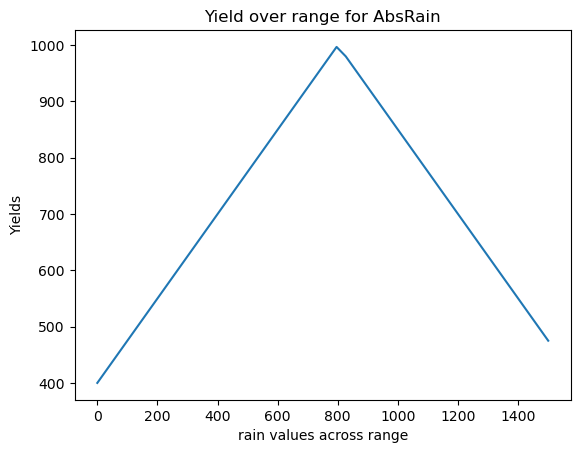

In [260]:
growing_rain_yield_functions[4].plot_function()

In [261]:
# upper and lower, range in which if its not in range, it just doesn't get picked
def insurance_neg_yields(yield_func, lower_threshold, upper_threshold):
    def inner_function(x):
        final_output = []
        # ok there's definitely a better way to write this 

        if len(x.shape) == 1:
          for i in range(len(x)):
            if x[i] < lower_threshold or x[i] > upper_threshold:
                final_output.append(- yield_to_cash_func(yield_func.return_yield(x[i])))
            else: 
                final_output.append(0)
        elif len(x.shape) == 2:

        # there's probably a way to optimize this using np.piecewise but its buggy
          for i in range(len(x)):
              output = []
              for j in range(len(x[i])):
                if x[i][j] < lower_threshold or x[i][j] > upper_threshold:
                    output.append(- yield_to_cash_func(yield_func.return_yield(x[i][j])))
                else:
                  output.append(0)
              final_output.append(np.array(output))
        return np.array(final_output)
      #   
    return inner_function

Text(0.5, 0, 'AbsRain values across range')

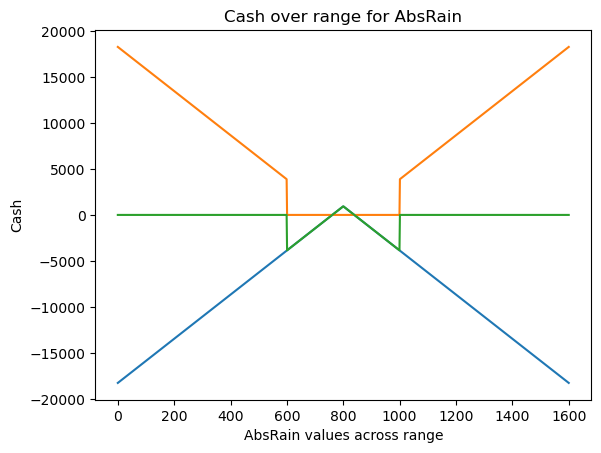

In [262]:
total_values = np.linspace(0, 1600, 1000)
plt.plot(total_values, yield_to_cash_func(growing_rain_yield_functions[4].return_yield(total_values)))
plt.plot(total_values, insurance_neg_yields(growing_rain_yield_functions[4], 600, 1000)(total_values))
list_to_plot = yield_to_cash_func(growing_rain_yield_functions[4].return_yield(total_values)) + insurance_neg_yields(growing_rain_yield_functions[4], 600, 1000)(total_values)
plt.plot(total_values, list_to_plot)

plt.title(f"Cash over range for {growing_rain_yield_functions[4].name}")
plt.ylabel("Cash")
plt.xlabel(f"{growing_rain_yield_functions[4].name} values across range")

In [263]:
rain_to_insurance = insurance_neg_yields(growing_rain_yield_functions[4], 600, 1000)
# this calculator takes in an input the payout from insurance without the premiums
# finds the premium that should be given to maintain expected value = 0
def premium_calculator(rain_to_insurance, 
                                 n_trials = 100000, 
                                 mean = g_mean, 
                                 std = g_std, 
                                 seed=98765):
    # generate the rainfall
    rng = np.random.default_rng(seed)
    grow_rain = np.random.normal(mean - 200, 2.5*std, size = (n_trials)) # M by N matrix 
    insurance_payout = rain_to_insurance(grow_rain)
    total_payout = np.sum(insurance_payout)
    num_payout = np.sum([1 if x > 0 else 0 for x in insurance_payout])
    percentage_payout = (float(num_payout)/ float((n_trials)))
    # expected value = 0 = n_trials * premium - total_payout 
    # -> total_payout / n_trials = premium
    premium = total_payout / n_trials
    return premium, total_payout, n_trials, percentage_payout


In [264]:
premium_calculator(rain_to_insurance)

(250.91277761250575, 25091277.761250574, 100000, 0.05233)

In [265]:
def full_sim(rain_to_yield, 
              lower_threshold, 
              upper_threshold, 
              n_trials,
              n_years, 
              yield_variability):
    
    # set up big guy
    rain_to_insurance = insurance_neg_yields(rain_to_yield, lower_threshold, upper_threshold)
    premium = premium_calculator(rain_to_insurance)[0]
    sim_out = insurance_sim_rain(n_trials = n_trials, 
            n_years = n_years, 
            yield_simulator = YieldSimulator(rain_to_yield), 
            yield_to_cash = yield_to_cash_func,
            insurance_policy= rain_to_insurance,
            yield_variability= yield_variability,
            premium = premium
                    )
    # plot yield function and insurance output
    total_values = np.linspace(0, 1600, 1000)
    plt.plot(total_values, yield_to_cash_func(rain_to_yield.return_yield(total_values)))
    plt.plot(total_values, rain_to_insurance(total_values))
    list_to_plot = yield_to_cash_func(rain_to_yield.return_yield(total_values)) + rain_to_insurance(total_values)
    plt.plot(total_values, list_to_plot)

    plt.title(f"Cash over range for {rain_to_yield.name}")
    plt.ylabel("Cash")
    plt.xlabel(f"{rain_to_yield.name} values across range")
    
    
    plt.figure()
    # plot sim output
    #print(sim_out[0].shape)
    plt.plot(np.mean(sim_out[0][:,:], axis = 1), color = 'red', label = "rain growing")
    #plt.plot(np.mean(sim_out[0][:,:,1], axis = 1), color = 'blue', label = 'rain harvest')
    plt.legend()
    plt.figure()
    plt.plot(np.mean(sim_out[1], axis = 1), color = 'red', label = 'predicted yield')
    plt.plot(np.mean(sim_out[2], axis = 1), color = 'blue', label = 'actual yield')
    plt.legend()
    plt.figure()
    plt.plot(np.mean(sim_out[3], axis = 1), color = 'black', label = 'no policy cash')
    plt.plot(np.mean(sim_out[4], axis = 1), color = 'green', label = 'with policy cash')
    plt.plot(np.mean(sim_out[5], axis = 1), color = 'purple', label = 'direct ins payouts')
    plt.legend()
    print(f"Premium such that expected value will be 0 is: {premium}")

AbsRain
Premium such that expected value will be 0 is: 1037.2348828880442


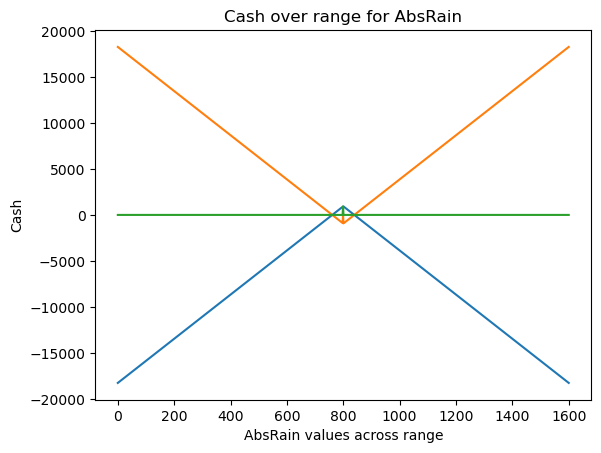

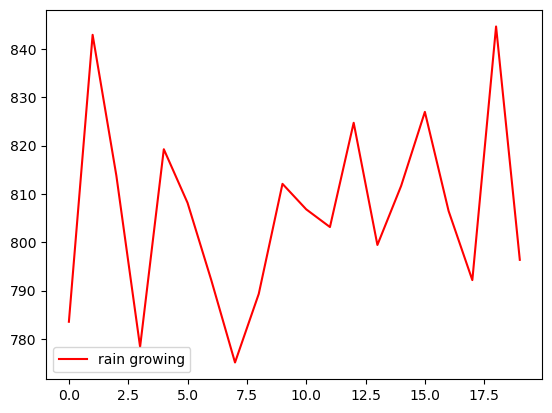

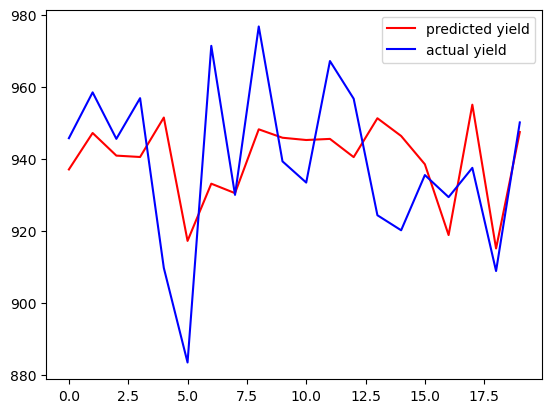

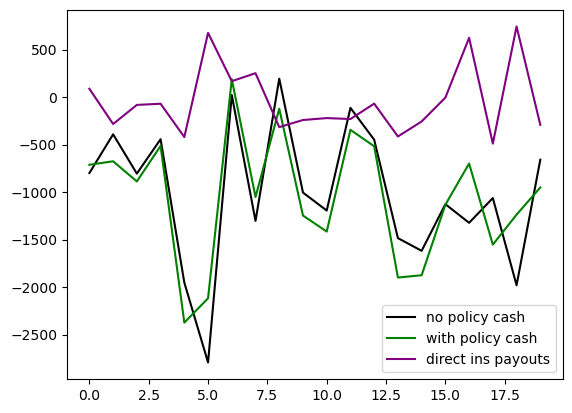

In [281]:
full_sim(rain_to_yield = growing_rain_yield_functions[4], 
              lower_threshold = 799, 
              upper_threshold = 800, 
              n_trials = 20,
              n_years = 20, 
              yield_variability = 100)

AbsRain
Premium such that expected value will be 0 is: 422.91910512051106


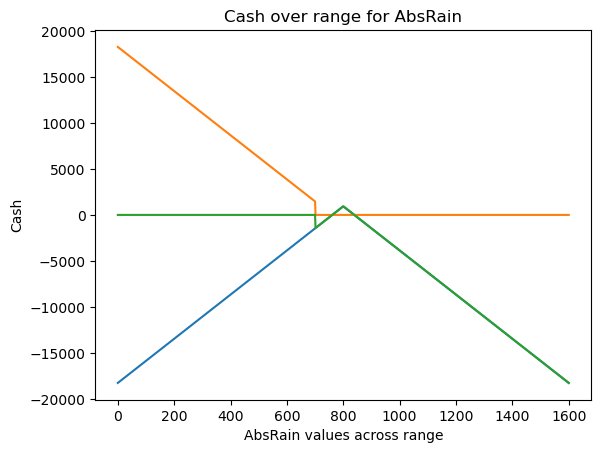

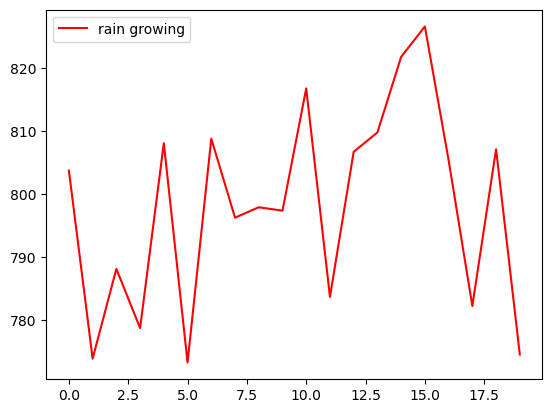

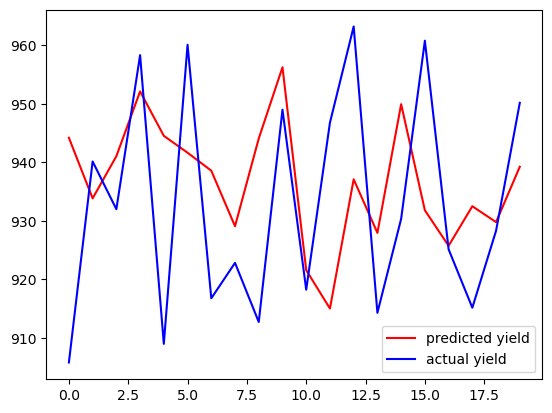

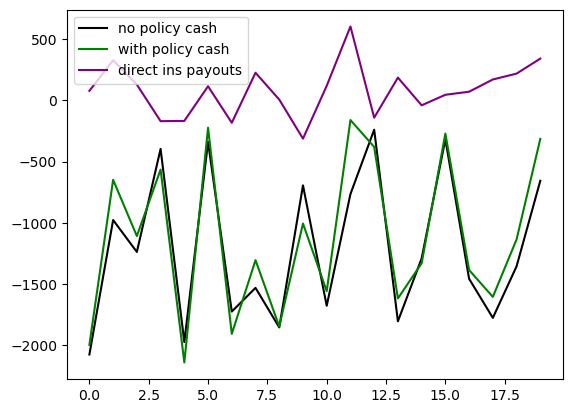

In [277]:
full_sim(rain_to_yield = growing_rain_yield_functions[4], 
              lower_threshold = 700, 
              upper_threshold = 10000, 
              n_trials = 20,
              n_years = 20, 
              yield_variability = 100)